# Capstone project: Nigerian loan default prediction

This is my capstone project for the machine learning and AI certificate course with Imperial College. The aim of the project is to put to test a number of the techniques taught in the course.

The project selected is sourced from Zindi (a website with African data science competitions) and the specific project is entitled 'Loan Default Prediction Challenge'. The details can be found at  https://zindi.africa/competitions/data-science-nigeria-challenge-1-loan-default-prediction.

The code is organised into the following sections
- Importing libraries
1. Loading data
2. EDA
3. Data processing and feature engineering
4. Train multiple machine learning models (first attempt, with limited hyper-paramter tuning)
5. Revisit feature engineering and balance the data
6. Train a machine learning model (second attempt)
7. Selecting the best model, deeper hyper-parameter tuning
8. Conclusions

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings # Import the warnings module

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Section 1: Load the data

Note that I have decided to use only the train data and to partition it into a train and test set. This is because I only have the Y value for the train set. Since this is a competition, you are supposed to submit your answers on the test set and get back your score. I don't want to slow my process so plan to use only the train set for this exercise.  

In [2]:
# Mount Google Drive
from google.colab import drive # Import the drive module from google.colab
drive.mount('/content/drive')

# Change directory
drive_path = os.path.join('/content/drive/My Drive/Colab_Notebooks/Zindi/NigeriaLoans/Data')
%cd {drive_path}

#Load demographic data
train_demog = pd.read_csv('traindemographics.csv')
train_demog_df = pd.DataFrame(train_demog)
#print(train_demog_df.head())

#test_demog = pd.read_csv('testdemographics.csv')
#test_demog_df = pd.DataFrame(test_demog)
#print(test_demog_df.head())

#Load previous loans data
train_prev = pd.read_csv('trainprevloans.csv')
train_prev_df = pd.DataFrame(train_prev)
#print(train_prev_df.head())

#test_prev = pd.read_csv('testprevloans.csv')
#test_prev_df = pd.DataFrame(test_prev)
#print(test_prev_df.head())

#Load new loan data
train_perf = pd.read_csv('trainperf.csv')
train_perf_df = pd.DataFrame(train_perf)
print('train',train_perf_df.head())

#test_perf = pd.read_csv('testperf.csv')
#test_perf_df = pd.DataFrame(test_perf)
#print('test',test_perf_df.head())

Mounted at /content/drive
/content/drive/My Drive/Colab_Notebooks/Zindi/NigeriaLoans/Data
train                          customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301994762          12   
1  8a85886e54beabf90154c0a29ae757c0     301965204           2   
2  8a8588f35438fe12015444567666018e     301966580           7   
3  8a85890754145ace015429211b513e16     301999343           3   
4  8a858970548359cc0154883481981866     301962360           9   

                 approveddate                creationdate  loanamount  \
0  2017-07-25 08:22:56.000000  2017-07-25 07:22:47.000000     30000.0   
1  2017-07-05 17:04:41.000000  2017-07-05 16:04:18.000000     15000.0   
2  2017-07-06 14:52:57.000000  2017-07-06 13:52:51.000000     20000.0   
3  2017-07-27 19:00:41.000000  2017-07-27 18:00:35.000000     10000.0   
4  2017-07-03 23:42:45.000000  2017-07-03 22:42:39.000000     40000.0   

   totaldue  termdays referredby good_bad_flag  
0   34500.0        30    

# Section 2 Exploratory Data Analysis

Training Demographics shape: (4346, 9)
Training Prev Loans shape: (18183, 12)
Training Performance shape: (4368, 10)

Missing values in train_demog_df:


,missing_count,missing_pct
bank_branch_clients,4295,98.83
level_of_education_clients,3759,86.49
employment_status_clients,648,14.91



Missing values in train_prev_df:


,missing_count,missing_pct
referredby,17157,94.36



Missing values in train_perf_df:


,missing_count,missing_pct
referredby,3781,86.56



Numerical summary for training demographics:


,longitude_gps,latitude_gps
count,4346.000000,4346.000000
mean,4.626189,7.251356
std,7.184832,3.055052
min,-118.247009,-33.868818
25%,3.354953,6.470610
50%,3.593302,6.621888
75%,6.545220,7.425052
max,151.209290,71.228069


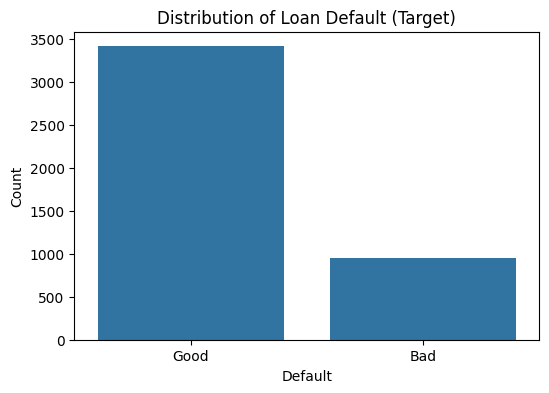

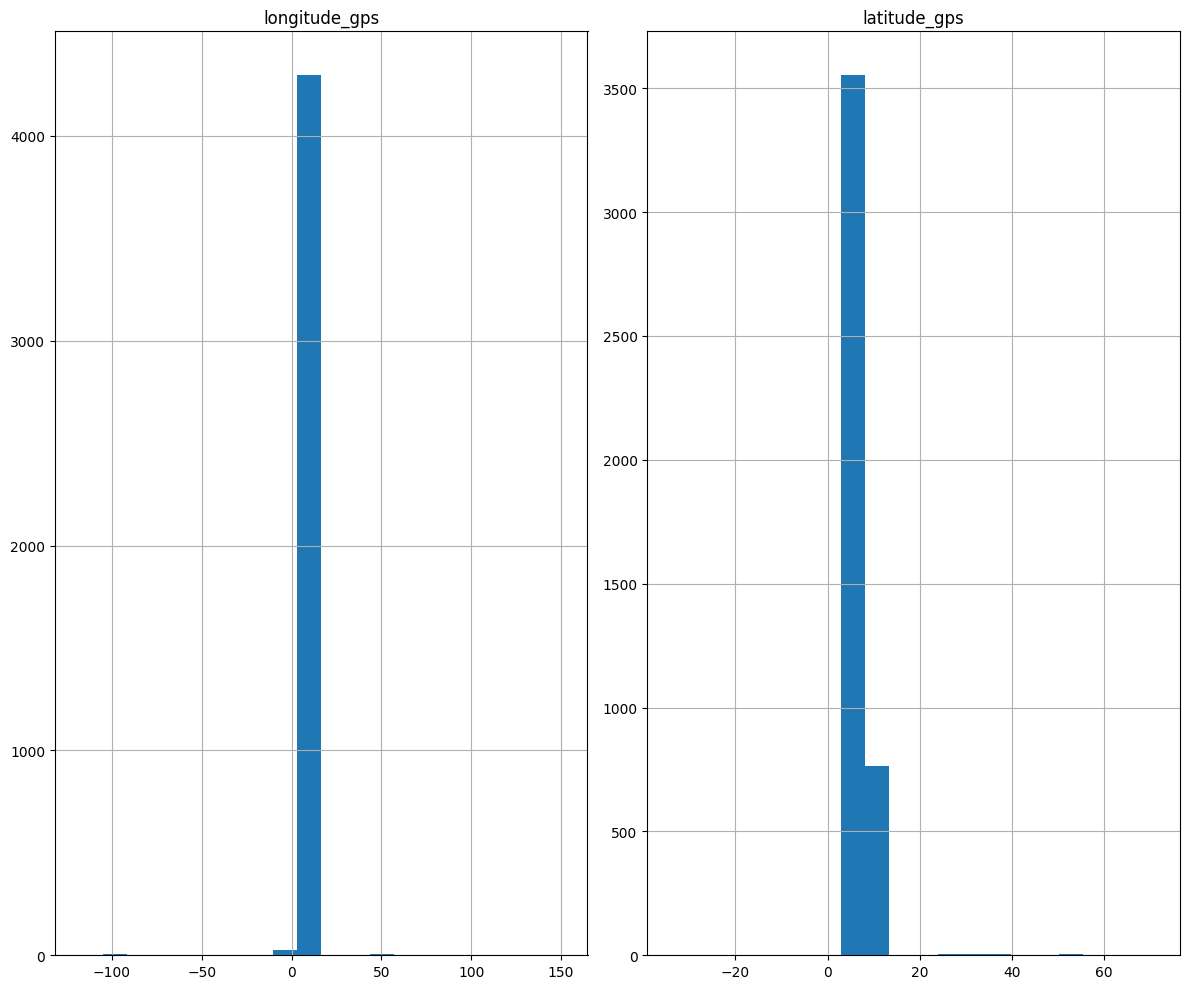

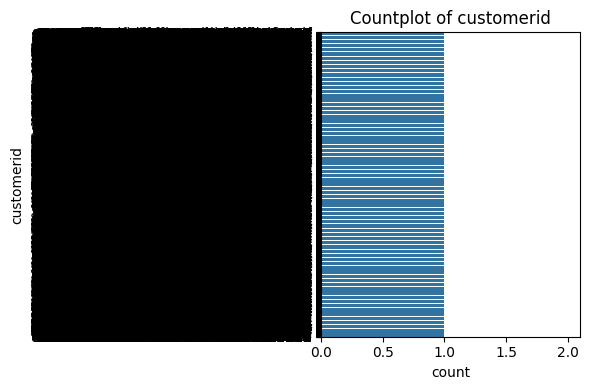

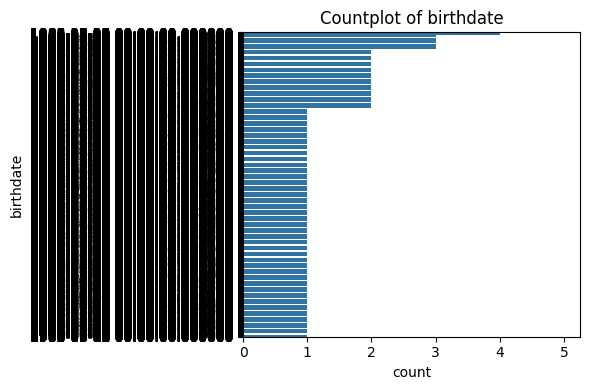

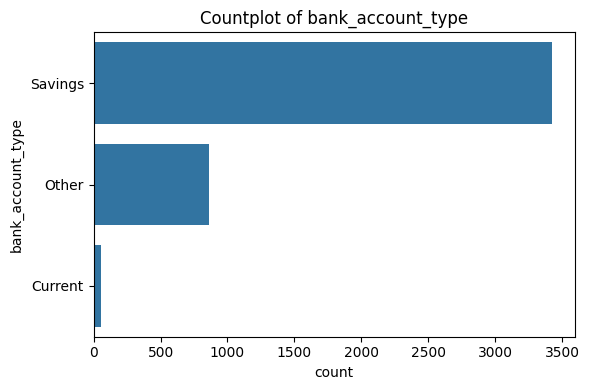

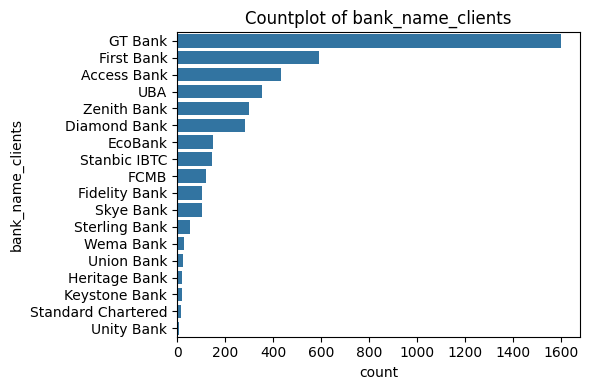

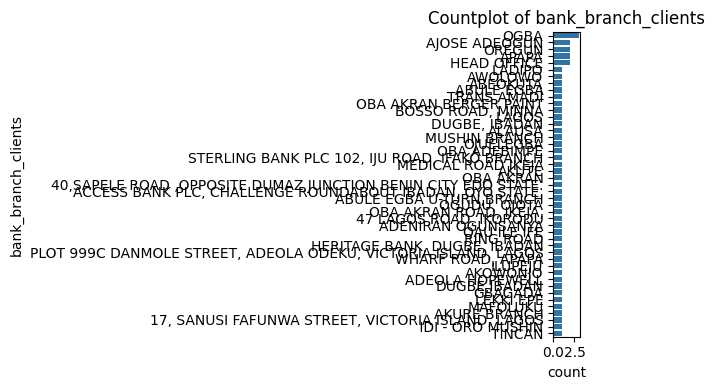

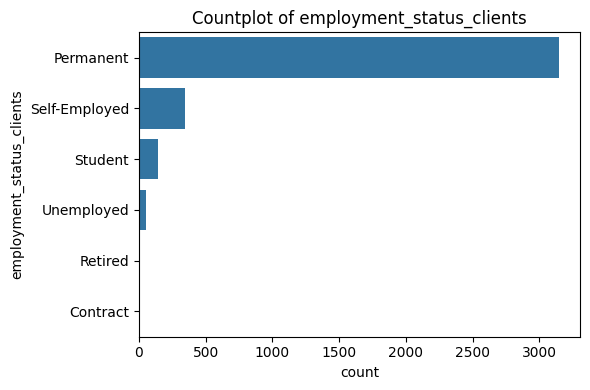

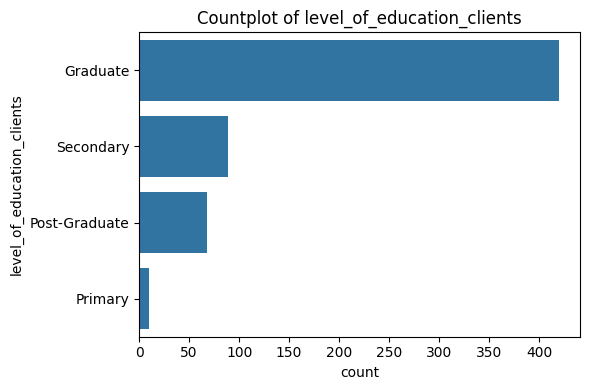

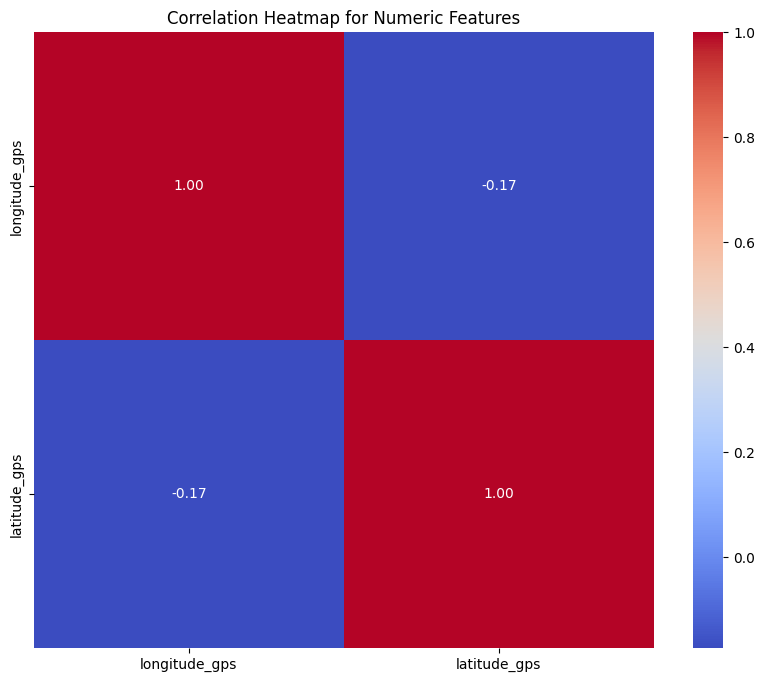

In [3]:
# 2.1 Dataset Shapes
print("Training Demographics shape:", train_demog_df.shape)
print("Training Prev Loans shape:",  train_prev_df.shape)
print("Training Performance shape:", train_perf_df.shape)

# 2.2 Missing Values Summary
def missing_summary(df, name):
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    pct = (missing / len(df) * 100).round(2)
    summary = pd.DataFrame({'missing_count': missing, 'missing_pct': pct})
    print(f"\nMissing values in {name}:")
    display(summary)

missing_summary(train_demog_df, 'train_demog_df')
missing_summary(train_prev_df,  'train_prev_df')
missing_summary(train_perf_df,  'train_perf_df')

# 2.3 Summary Statistics
print("\nNumerical summary for training demographics:")
display(train_demog_df.describe())

# 2.4 Target Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='good_bad_flag', data=train_perf_df)
plt.title('Distribution of Loan Default (Target)')
plt.xlabel('Default')
plt.ylabel('Count')
plt.show()

# 2.5 Numeric Feature Distributions
numeric_cols = train_demog_df.select_dtypes(include=[np.number]).columns.tolist()
train_demog_df[numeric_cols].hist(figsize=(12,10), bins=20)
plt.tight_layout()
plt.show()

# 2.6 Categorical Feature Distributions
cat_cols = train_demog_df.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(y=col, data=train_demog_df, order=train_demog_df[col].value_counts().index)
    plt.title(f'Countplot of {col}')
    plt.tight_layout()
    plt.show()

# 2.7 Correlation Heatmap
corr = train_demog_df[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap for Numeric Features")
plt.show()

# Section 3: Data processing and feature engineering

**Flattening the previous loans file**

The task involves considering new loans and likelihood of default by customer. But the previous loans file includes multiple loans per customer. So we want to combine the customer data (train_demog file) with the previous loans data (train_prev) so that we have a single line for each customer. This means that we need to flatten the train_prev file into a single line. We also want to calculate more meaningful columns from the previous loans data such as the number of loans, the aggregate value of loans etc.

# Example

The example below shows the four loans to a single customer. These are one month loans (and one is a two month loan). The amounts gradually increased from 10000 to 30000. Three of the loans were repaid one day before the due date. One was repaid on the due date.

The useful information here is likely to be the number of loans, the average amount, the largest amount, the average term, the longest term, the difference between the due date and the repayment date (-1 = one day early, 0 = on due date, 1 = one day late etc). The length of time the customer has been a borrower (longer is probably better) date of the most recent loan (more recent is likely to be better) are also probably relevant.

We can delete the time of day from the date columns.

In [4]:
#Show loans for a single customer in train_prev_df file
customer = '8a1a1e7e4f707f8b014f797718316cad'
display(train_prev_df[train_prev_df['customerid'] == customer])

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
5216,8a1a1e7e4f707f8b014f797718316cad,301620412,1,2016-05-13 15:29:37.000000,2016-05-13 14:29:31.000000,10000.0,13000.0,30,2016-06-15 00:03:33.000000,NaN,2016-06-13 00:00:00.000000,2016-06-14 10:41:13.000000
7999,8a1a1e7e4f707f8b014f797718316cad,301916386,3,2017-05-23 14:21:42.000000,2017-05-23 13:20:30.000000,20000.0,24500.0,30,2017-06-21 21:58:00.000000,NaN,2017-06-22 00:00:00.000000,2017-06-21 21:47:51.000000
16602,8a1a1e7e4f707f8b014f797718316cad,301947045,4,2017-06-21 22:09:51.000000,2017-06-21 21:09:44.000000,30000.0,39000.0,60,2017-07-26 19:48:11.000000,NaN,2017-07-21 00:00:00.000000,2017-07-20 15:05:33.000000
17546,8a1a1e7e4f707f8b014f797718316cad,301632940,2,2016-06-15 11:22:38.000000,2016-06-15 10:22:32.000000,10000.0,13000.0,30,2016-07-15 13:59:02.000000,NaN,2016-07-15 00:00:00.000000,2016-07-15 13:43:58.000000


In [5]:
# add a new column with difference between due date and repayment date
# Convert date columns to datetime objects
train_prev_df['firstduedate'] = pd.to_datetime(train_prev_df['firstduedate'])
train_prev_df['firstrepaiddate'] = pd.to_datetime(train_prev_df['firstrepaiddate'])

# Calculate the difference in days
train_prev_df['repayment_difference_days'] = (train_prev_df['firstrepaiddate'] - train_prev_df['firstduedate']).dt.days

# Display the head of the DataFrame with the new column
display(train_prev_df.head())

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,repayment_difference_days
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14,2016-09-01 15:51:43,-13
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30,2017-05-26 00:00:00,-4
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04,2017-04-26 22:03:47,22
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24,2017-04-24 00:48:43,0
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03,2017-07-14 21:08:35,11


## Aggregate previous loans data

Aggregate features from `train_prev_df` by `customerid` to create a summary for each customer's previous loan history in a single row.


In [6]:
# Drop specified date columns from train_prev_df before aggregation
cols_to_drop_prev = ['approveddate', 'creationdate', 'closeddate']
train_prev_df_processed = train_prev_df.drop(columns=cols_to_drop_prev, errors='ignore')

# Identify numerical and categorical columns
numerical_cols = train_prev_df_processed.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_prev_df_processed.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove 'systemloanid' and 'loannumber' from numerical columns as they are identifiers
if 'systemloanid' in numerical_cols:
    numerical_cols.remove('systemloanid')
if 'loannumber' in numerical_cols:
    numerical_cols.remove('loannumber')
# Remove 'customerid' from categorical columns as it's the grouping key
if 'customerid' in categorical_cols:
    categorical_cols.remove('customerid')

# Define aggregation for numerical columns, excluding 'std'
agg_num = {col: ['mean', 'sum', 'count', 'max'] for col in numerical_cols}

# Add aggregation for the new 'repayment_difference_days' column, excluding 'std'
if 'repayment_difference_days' in train_prev_df_processed.columns:
    agg_num['repayment_difference_days'] = ['mean', 'min', 'max']

# Define aggregation for categorical columns (using mode)
agg_cat = {col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in categorical_cols}
# Rename the lambda function for clarity in the resulting column names
for col in categorical_cols:
    agg_cat[col].__name__ = 'mode'

# Combine aggregation dictionaries
agg_dict = {**agg_num, **agg_cat}

# Aggregate train_prev_df by customerid
train_prev_agg_df = train_prev_df_processed.groupby('customerid').agg(agg_dict)

# Flatten the multi-level column names for numerical features
train_prev_agg_df.columns = ['_'.join(col).strip() for col in train_prev_agg_df.columns.values]

# For categorical columns aggregated with lambda, the column name is already flat.
# Fix column names for categorical aggregations
for col in categorical_cols:
    train_prev_agg_df.rename(columns={f'{col}_<lambda_0>': f'{col}_mode'}, inplace=True)

# Create the 'ever_late_repayment' binary feature
# A late repayment is indicated by a positive 'repayment_difference_days'
if 'repayment_difference_days_max' in train_prev_agg_df.columns:
    train_prev_agg_df['ever_late_repayment'] = (train_prev_agg_df['repayment_difference_days_max'] > 0).astype(int)
else:
     train_prev_agg_df['ever_late_repayment'] = 0 # Default to 0 if no repayment difference data


# Display the head and shape of the aggregated dataframe
display(train_prev_agg_df.head())
print("Aggregated Previous Loans shape:", train_prev_agg_df.shape)

,loanamount_mean,loanamount_sum,loanamount_count,loanamount_max,totaldue_mean,totaldue_sum,totaldue_count,totaldue_max,termdays_mean,termdays_sum,termdays_count,termdays_max,repayment_difference_days_mean,repayment_difference_days_min,repayment_difference_days_max,referredby_mode,ever_late_repayment
customerid,,,,,,,,,,,,,,,,,
8a1088a0484472eb01484669e3ce4e0b,10000.000000,10000.0,1,10000.0,11500.000000,11500.0,1,11500.0,15.000000,15,1,15,6.000000,6,6,NaN,1
8a1a1e7e4f707f8b014f797718316cad,17500.000000,70000.0,4,30000.0,22375.000000,89500.0,4,39000.0,37.500000,150,4,60,-0.250000,-1,1,NaN,1
8a1a32fc49b632520149c3b8fdf85139,12857.142857,90000.0,7,20000.0,15214.285714,106500.0,7,24500.0,19.285714,135,7,30,-0.428571,-2,1,NaN,1
8a1eb5ba49a682300149c3c068b806c7,16250.000000,130000.0,8,30000.0,20300.000000,162400.0,8,39000.0,33.750000,270,8,60,-3.125000,-13,8,NaN,1
8a1edbf14734127f0147356fdb1b1eb2,10000.000000,20000.0,2,10000.0,12250.000000,24500.0,2,13000.0,22.500000,45,2,30,-4.000000,-8,0,NaN,0


Aggregated Previous Loans shape: (4359, 17)


## Merge dataframes


Having flattened the previous loans file so there is a single line for each customerid we can now merge it with the demographic information for each customer and the new loans information for each customer.

The dataframes to be merged are demographics data (`train_demog_df`), previous loans data ('train_prev_df') and new loans/performance data (`train_perf_df`) using `customerid`.


In [7]:
# Merge train_demog_df and train_prev_agg_df first
train_merged_df = pd.merge(train_demog_df, train_prev_agg_df, on='customerid', how='left')

# Now merge the result with train_perf_df
train_merged_df = pd.merge(train_merged_df, train_perf_df, on='customerid', how='left')

# Add a symbol before the column headings from train_perf_df (excluding 'customerid')
perf_cols = [col for col in train_perf_df.columns if col != 'customerid']
train_merged_df.rename(columns={col: f'perf_{col}' for col in perf_cols}, inplace=True)

# Display the head and shape of the final merged DataFrame
display(train_merged_df.head())
print("Final Merged Training Data shape:", train_merged_df.shape)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,loanamount_mean,...,ever_late_repayment,perf_systemloanid,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,perf_referredby,perf_good_bad_flag
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,10000.0,...,0.0,301964962.0,2.0,2017-07-05 14:29:48.000000,2017-07-05 13:29:42.000000,10000.0,13000.0,30.0,8a858899538ddb8e0153a780c56e34bb,Good
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,10000.0,...,1.0,301972172.0,2.0,2017-07-10 21:21:46.000000,2017-07-10 20:21:40.000000,10000.0,13000.0,30.0,NaN,Bad
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,10000.0,...,1.0,301976271.0,4.0,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,10000.0,13000.0,30.0,NaN,Good
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN,10000.0,...,1.0,301997763.0,2.0,2017-07-26 21:03:17.000000,2017-07-26 20:03:09.000000,10000.0,11500.0,15.0,NaN,Good
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Final Merged Training Data shape: (4346, 35)


In [8]:
#List the columns in the merged dataframe (5 columns per line)
pd.set_option('display.max_columns', None)
display(train_merged_df.columns)

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients',
       'loanamount_mean', 'loanamount_sum', 'loanamount_count',
       'loanamount_max', 'totaldue_mean', 'totaldue_sum', 'totaldue_count',
       'totaldue_max', 'termdays_mean', 'termdays_sum', 'termdays_count',
       'termdays_max', 'repayment_difference_days_mean',
       'repayment_difference_days_min', 'repayment_difference_days_max',
       'referredby_mode', 'ever_late_repayment', 'perf_systemloanid',
       'perf_loannumber', 'perf_approveddate', 'perf_creationdate',
       'perf_loanamount', 'perf_totaldue', 'perf_termdays', 'perf_referredby',
       'perf_good_bad_flag'],
      dtype='object')

## Handle missing values

Investigate which columns have missing values in merged dataset. Then develop a strategy to handle them.

In [9]:
# Calculate missing values
missing_values = train_merged_df.isnull().sum()

# Calculate percentage of missing values
missing_percentage = (missing_values / len(train_merged_df)) * 100

# Create a DataFrame to display the missing values
missing_df = pd.DataFrame({'missing_count': missing_values, 'missing_percent': missing_percentage})

# Filter to show only columns with missing values and sort by percentage
missing_df = missing_df[missing_df['missing_count'] > 0].sort_values(by='missing_percent', ascending=False)

# Display the missing values summary
print("Missing values summary for train_merged_df:")
display(missing_df)

Missing values summary for train_merged_df:


,missing_count,missing_percent
bank_branch_clients,4295,98.826507
perf_referredby,3896,89.645651
referredby_mode,3896,89.645651
level_of_education_clients,3759,86.493327
loanamount_mean,1074,24.712379
totaldue_count,1074,24.712379
loanamount_max,1074,24.712379
totaldue_mean,1074,24.712379
totaldue_sum,1074,24.712379
termdays_mean,1074,24.712379


# Discussion on missing values

**No previous loans data**
It appears that 24.7% of customer IDs have no previous loan history. It would be easier to create a model by removing these people from the project, but the task requires that we also make predictions of likelihood of default for these people, so we will keep them in.   

**No new/performance loans data**
It also appears that 24.6% of customers have no performance loans data. This seems strange as we are trying to predict if these new loans will default, so in this case there is nothing to predict and we will have to leave them out.

**Columns with >80% of data missing**
There are four columns with more than 80% of the data missing. We will delete these four columns

In [10]:
# Drop rows where 'perf_systemloanid' is missing
initial_rows = train_merged_df.shape[0]
train_merged_df.dropna(subset=['perf_systemloanid'], inplace=True)
rows_after_dropping_perf_missing = train_merged_df.shape[0]
print(f"Dropped {initial_rows - rows_after_dropping_perf_missing} rows with missing 'perf_systemloanid'.")
print(f"Remaining rows: {rows_after_dropping_perf_missing}")


# Calculate missing values after dropping rows
missing_values = train_merged_df.isnull().sum()

# Calculate percentage of missing values
missing_percentage = (missing_values / len(train_merged_df)) * 100

# Create a DataFrame to display the missing values
missing_df = pd.DataFrame({'missing_count': missing_values, 'missing_percent': missing_percentage})

# Filter to show only columns with missing values and sort by percentage
missing_df = missing_df[missing_df['missing_count'] > 0].sort_values(by='missing_percent', ascending=False)

# Display the missing values summary after dropping rows
print("\nMissing values summary for train_merged_df after dropping rows with missing perf_systemloanid:")
display(missing_df)


# Drop columns with very high missing percentages (>80%)
cols_to_drop = missing_df[missing_df['missing_percent'] > 80].index.tolist()
train_merged_df = train_merged_df.drop(columns=cols_to_drop)
print(f"\nDropped columns with >80% missing values: {cols_to_drop}")


# Verify missing values after handling
print("\nMissing values summary after handling:")
display(train_merged_df.isnull().sum()[train_merged_df.isnull().sum() > 0])


Dropped 1069 rows with missing 'perf_systemloanid'.
Remaining rows: 3277

Missing values summary for train_merged_df after dropping rows with missing perf_systemloanid:


,missing_count,missing_percent
bank_branch_clients,3244,98.992981
level_of_education_clients,2834,86.481538
referredby_mode,2827,86.267928
perf_referredby,2827,86.267928
employment_status_clients,493,15.044248
loanamount_sum,5,0.152579
loanamount_mean,5,0.152579
loanamount_count,5,0.152579
loanamount_max,5,0.152579
totaldue_count,5,0.152579



Dropped columns with >80% missing values: ['bank_branch_clients', 'level_of_education_clients', 'referredby_mode', 'perf_referredby']

Missing values summary after handling:


,0
employment_status_clients,493
loanamount_mean,5
loanamount_sum,5
loanamount_count,5
loanamount_max,5
totaldue_mean,5
totaldue_sum,5
totaldue_count,5
totaldue_max,5
termdays_mean,5


**Conclusion**
Having dropped the customers with no new/perf loans these people correspond largely with the customers who have no loan history. There are just 5 customers with new/perf loans but no loan history. So to tidy up the file we will drop these 5 customers

In [11]:
# Drop rows where 'loanamount_mean' is missing
initial_rows = train_merged_df.shape[0]
train_merged_df.dropna(subset=['loanamount_mean'], inplace=True)
rows_after_dropping_loanamount_missing = train_merged_df.shape[0]
print(f"Dropped {initial_rows - rows_after_dropping_loanamount_missing} rows with missing 'loanamount_mean'.")
print(f"Remaining rows: {rows_after_dropping_loanamount_missing}")

# Verify that there are no more missing values in loanamount_mean
print("\nMissing values in loanamount_mean after dropping rows:")
display(train_merged_df['loanamount_mean'].isnull().sum())


Dropped 5 rows with missing 'loanamount_mean'.
Remaining rows: 3272

Missing values in loanamount_mean after dropping rows:


np.int64(0)

## Feature engineering

Create new features that could be useful for the prediction model.


In [12]:
# Extract age from 'birthdate'
# Use a consistent reference date for when we want to know the age (e.g., the latest date in the dataset or a fixed date)
reference_date = pd.to_datetime('2017-08-01') # Using a date slightly after the last date in train_perf_df for consistency

# Check if 'birthdate' column exists and its data type
if 'birthdate' in train_merged_df.columns:
    print(f"'birthdate' column exists. Data type: {train_merged_df['birthdate'].dtype}")
    try:
        train_merged_df['birthdate'] = pd.to_datetime(train_merged_df['birthdate'])
        train_merged_df['age'] = (reference_date - train_merged_df['birthdate']).dt.days / 365.25

        # Bucket age into 5 equal categories and store the bins
        # Handle cases where qcut might fail due to limited unique values
        try:
            age_bins = pd.qcut(train_merged_df['age'], q=5, labels=False, duplicates='drop', retbins=True)
            train_merged_df['age_bucket'] = age_bins[0]
            bins = age_bins[1]

            # Display the age ranges for each bucket
            print("Age bucket ranges:")
            for i in range(len(bins) - 1):
                print(f"Bucket {i}: {bins[i]:.2f} to {bins[i+1]:.2f}")

            # Display the value counts of the new 'age_bucket' column
            print("\nDistribution of age buckets:")
            display(train_merged_df['age_bucket'].value_counts().sort_index())

        except ValueError as e:
            print(f"Could not create age buckets: {e}")
            print("This might happen if there are not enough unique age values for 5 quantiles.")
            train_merged_df['age_bucket'] = np.nan # Assign NaN if bucketing fails

    except Exception as e:
        print(f"Error converting 'birthdate' to datetime or calculating age: {e}")
else:
    print("'birthdate' column not found in the DataFrame.")


# Extract features related to loan timing
# Define relevant date columns that are expected to be in train_merged_df with the new prefix
relevant_date_cols = ['perf_approveddate', 'perf_creationdate',
                      'approveddate_mode', 'creationdate_mode', 'closeddate_mode', 'firstduedate_mode', 'firstrepaiddate_mode']

# Filter the list to only include columns actually present in the DataFrame
date_cols_present = [col for col in relevant_date_cols if col in train_merged_df.columns]

# Convert present date columns to datetime objects (already done in previous step, but re-ensuring)
for col in date_cols_present:
    train_merged_df[col] = pd.to_datetime(train_merged_df[col], errors='coerce')


# Calculate time differences for previous loans based on mode
if 'approveddate_mode' in train_merged_df.columns and 'creationdate_mode' in train_merged_df.columns:
    train_merged_df['time_to_approve_prev_mode'] = (train_merged_df['approveddate_mode'] - train_merged_df['creationdate_mode']).dt.days

if 'firstduedate_mode' in train_merged_df.columns and 'approveddate_mode' in train_merged_df.columns:
    train_merged_df['approve_to_first_due_prev_mode'] = (train_merged_df['firstduedate_mode'] - train_merged_df['approveddate_mode']).dt.days

if 'firstrepaiddate_mode' in train_merged_df.columns and 'firstduedate_mode' in train_merged_df.columns:
    train_merged_df['first_due_to_repaid_prev_mode'] = (train_merged_df['firstrepaiddate_mode'] - train_merged_df['firstduedate_mode']).dt.days

if 'closeddate_mode' in train_merged_df.columns and 'creationdate_mode' in train_merged_df.columns:
    train_merged_df['loan_duration_prev_mode'] = (train_merged_df['closeddate_mode'] - train_merged_df['creationdate_mode']).dt.days


# Create features from the previous loan aggregates (excluding interest rates and specific ratios/diffs)
# Ratio of current loan amount to average previous loan amount
if 'perf_loanamount' in train_merged_df.columns and 'loanamount_mean' in train_merged_df.columns:
    train_merged_df['perf_loanamount_ratio_mean'] = train_merged_df['perf_loanamount'] / train_merged_df['loanamount_mean']

# Difference between current loan amount and average previous loan amount
if 'perf_loanamount' in train_merged_df.columns and 'loanamount_mean' in train_merged_df.columns:
    train_merged_df['perf_loanamount_diff_mean'] = train_merged_df['perf_loanamount'] - train_merged_df['loanamount_mean']

# Ratio of current termdays to average previous termdays
if 'perf_termdays' in train_merged_df.columns and 'termdays_mean' in train_merged_df.columns:
    train_merged_df['perf_termdays_ratio_mean'] = train_merged_df['perf_termdays'] / train_merged_df['termdays_mean']

# Difference between current termdays and average previous termdays
if 'perf_termdays' in train_merged_df.columns and 'termdays_mean' in train_merged_df.columns:
    train_merged_df['perf_termdays_diff_mean'] = train_merged_df['perf_termdays'] - train_merged_df['termdays_mean']

# Location features (simple example: distance from a central point, or clustering later if needed)
# For now, we'll keep the raw coordinates. Clustering could be a later step.

# Define the list of date columns to drop after feature extraction
date_cols_to_drop = [col for col in relevant_date_cols if col in train_merged_df.columns]
if 'birthdate' in train_merged_df.columns:
    date_cols_to_drop.append('birthdate')
# Add other date columns from the perf_df that might have been included and are not needed for engineered features
date_cols_to_drop.extend(['perf_approveddate', 'perf_creationdate', 'perf_firstduedate', 'perf_firstrepaiddate'])
date_cols_to_drop = list(set(date_cols_to_drop)) # Remove duplicates

# Drop original date columns
train_merged_df = train_merged_df.drop(columns=date_cols_to_drop, errors='ignore')


# Display the head and shape of the DataFrame with new features
display(train_merged_df.head())
print("Training Data shape after feature engineering:", train_merged_df.shape)

'birthdate' column exists. Data type: object
Age bucket ranges:
Bucket 0: 21.34 to 27.72
Bucket 1: 27.72 to 30.88
Bucket 2: 30.88 to 33.76
Bucket 3: 33.76 to 37.83
Bucket 4: 37.83 to 55.80

Distribution of age buckets:


,count
age_bucket,
0,655
1,654
2,654
3,654
4,655


,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,loanamount_mean,loanamount_sum,loanamount_count,loanamount_max,totaldue_mean,totaldue_sum,totaldue_count,totaldue_max,termdays_mean,termdays_sum,termdays_count,termdays_max,repayment_difference_days_mean,repayment_difference_days_min,repayment_difference_days_max,ever_late_repayment,perf_systemloanid,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,perf_good_bad_flag,age,age_bucket,perf_loanamount_ratio_mean,perf_loanamount_diff_mean,perf_termdays_ratio_mean,perf_termdays_diff_mean
0,8a858e135cb22031015cbafc76964ebd,Savings,3.319219,6.528604,GT Bank,NaN,10000.0,10000.0,1.0,10000.0,11500.0,11500.0,1.0,11500.0,15.0,15.0,1.0,15.0,-1.000000,-1.0,-1.0,0.0,301964962.0,2.0,10000.0,13000.0,30.0,Good,43.808350,4,1.000000,0.0,2.0,15.0
1,8a858e275c7ea5ec015c82482d7c3996,Savings,3.325598,7.119403,Sterling Bank,Permanent,10000.0,10000.0,1.0,10000.0,13000.0,13000.0,1.0,13000.0,30.0,30.0,1.0,30.0,3.000000,3.0,3.0,1.0,301972172.0,2.0,10000.0,13000.0,30.0,Bad,31.526352,2,1.000000,0.0,1.0,0.0
2,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,NaN,10000.0,30000.0,3.0,10000.0,12000.0,36000.0,3.0,13000.0,20.0,60.0,3.0,30.0,0.333333,-4.0,4.0,1.0,301976271.0,4.0,10000.0,13000.0,30.0,Good,30.335387,1,1.000000,0.0,1.5,10.0
3,8a858efd5ca70688015cabd1f1e94b55,Savings,3.362850,6.642485,GT Bank,Permanent,10000.0,10000.0,1.0,10000.0,11500.0,11500.0,1.0,11500.0,15.0,15.0,1.0,15.0,18.000000,18.0,18.0,1.0,301997763.0,2.0,10000.0,11500.0,15.0,Good,26.036961,0,1.000000,0.0,1.0,0.0
6,8a858ea05a859123015a8892914d15b7,Savings,3.365935,6.564823,Access Bank,Permanent,14000.0,70000.0,5.0,20000.0,17600.0,88000.0,5.0,24500.0,30.0,150.0,5.0,30.0,-3.200000,-7.0,0.0,0.0,301992494.0,6.0,20000.0,24500.0,30.0,Good,27.030801,0,1.428571,6000.0,1.0,0.0


Training Data shape after feature engineering: (3272, 34)


## Prepare data for modeling

Separate features and the target variable, and handle categorical features using one-hot encoding.Convert the target variable to a numerical code.


In [13]:
# Define the target variable and features
target = train_merged_df['perf_good_bad_flag'] # Updated target column name
features = train_merged_df.drop(columns=['perf_good_bad_flag', 'customerid', 'perf_systemloanid']) # Drop customerid and systemloanid as well as they are identifiers

# Convert the target variable to numerical
target = target.map({'Good': 0, 'Bad': 1})

# Identify categorical columns in the features DataFrame
categorical_cols = features.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns identified: {categorical_cols}")

# Apply one-hot encoding to the identified categorical columns
features = pd.get_dummies(features, columns=categorical_cols, drop_first=True) # drop_first=True to avoid multicollinearity

# Display the head and shape of the features DataFrame after encoding
display(features.head())
print("Features DataFrame shape after one-hot encoding:", features.shape)

Categorical columns identified: ['bank_account_type', 'bank_name_clients', 'employment_status_clients']


,longitude_gps,latitude_gps,loanamount_mean,loanamount_sum,loanamount_count,loanamount_max,totaldue_mean,totaldue_sum,totaldue_count,totaldue_max,termdays_mean,termdays_sum,termdays_count,termdays_max,repayment_difference_days_mean,repayment_difference_days_min,repayment_difference_days_max,ever_late_repayment,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,age,age_bucket,perf_loanamount_ratio_mean,perf_loanamount_diff_mean,perf_termdays_ratio_mean,perf_termdays_diff_mean,bank_account_type_Other,bank_account_type_Savings,bank_name_clients_Diamond Bank,bank_name_clients_EcoBank,bank_name_clients_FCMB,bank_name_clients_Fidelity Bank,bank_name_clients_First Bank,bank_name_clients_GT Bank,bank_name_clients_Heritage Bank,bank_name_clients_Keystone Bank,bank_name_clients_Skye Bank,bank_name_clients_Stanbic IBTC,bank_name_clients_Standard Chartered,bank_name_clients_Sterling Bank,bank_name_clients_UBA,bank_name_clients_Union Bank,bank_name_clients_Unity Bank,bank_name_clients_Wema Bank,bank_name_clients_Zenith Bank,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed
0,3.319219,6.528604,10000.0,10000.0,1.0,10000.0,11500.0,11500.0,1.0,11500.0,15.0,15.0,1.0,15.0,-1.000000,-1.0,-1.0,0.0,2.0,10000.0,13000.0,30.0,43.808350,4,1.000000,0.0,2.0,15.0,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,3.325598,7.119403,10000.0,10000.0,1.0,10000.0,13000.0,13000.0,1.0,13000.0,30.0,30.0,1.0,30.0,3.000000,3.0,3.0,1.0,2.0,10000.0,13000.0,30.0,31.526352,2,1.000000,0.0,1.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
2,5.746100,5.563174,10000.0,30000.0,3.0,10000.0,12000.0,36000.0,3.0,13000.0,20.0,60.0,3.0,30.0,0.333333,-4.0,4.0,1.0,4.0,10000.0,13000.0,30.0,30.335387,1,1.000000,0.0,1.5,10.0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3.362850,6.642485,10000.0,10000.0,1.0,10000.0,11500.0,11500.0,1.0,11500.0,15.0,15.0,1.0,15.0,18.000000,18.0,18.0,1.0,2.0,10000.0,11500.0,15.0,26.036961,0,1.000000,0.0,1.0,0.0,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
6,3.365935,6.564823,14000.0,70000.0,5.0,20000.0,17600.0,88000.0,5.0,24500.0,30.0,150.0,5.0,30.0,-3.200000,-7.0,0.0,0.0,6.0,20000.0,24500.0,30.0,27.030801,0,1.428571,6000.0,1.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


Features DataFrame shape after one-hot encoding: (3272, 52)


# Section 4: Train a machine learning model (initial attempt)

Select six different models suitable for classification tasks and see which one works best.

Use hyper-parameter tuning for each model to ensure we have a strong set of hyper-parameters.

In [14]:
# Section 4: Model Training & Hyperparameter Tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
# Add XGBoost and LightGBM
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 4.1 Train/Test Split (60% train, 40% validation)
X_train, X_val, y_train, y_val = train_test_split(
    features, target,
    test_size=0.4,
    random_state=32,
    stratify=target
)

# 4.2 Define models and hyperparameter grids
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, solver='saga', random_state=32),
        'params': {'C': [0.1, 1, 10], 'penalty': ['l2']}
    },
    'LassoLogistic': {
        'model': LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=32),
        'params': {'C': [0.1, 1, 10]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=32),
        'params': {'n_estimators': [100, 150], 'max_depth': [None, 10], 'min_samples_split': [2, 5]}
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=32),
        'params': {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=32),
        'params': {'n_estimators': [50, 100], 'learning_rate': [0.5, 1.0]}
    },
    'KNeighbors': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']}
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=32),
        'params': {'n_estimators': [100], 'max_depth': [3, 5]}
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=32),
        'params': {'n_estimators': [100], 'num_leaves': [31, 63]}
    }
}

# 4.3 Hyperparameter Tuning with GridSearchCV
best_estimators = {}
for name, cfg in models.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(
        cfg['model'],
        cfg['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    print(f"Best params for {name}: {grid.best_params_}")
    best_estimators[name] = grid.best_estimator_

# 4.4 Evaluation on Validation Set
for name, model in best_estimators.items():
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    print(f"\n=== {name} ===")
    print(classification_report(y_val, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_val, y_proba):.4f}")


Tuning LogisticRegression...
Best params for LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
Tuning LassoLogistic...
Best params for LassoLogistic: {'C': 1}
Tuning RandomForest...
Best params for RandomForest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Tuning GradientBoosting...
Best params for GradientBoosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Tuning AdaBoost...
Best params for AdaBoost: {'learning_rate': 0.5, 'n_estimators': 100}
Tuning KNeighbors...
Best params for KNeighbors: {'n_neighbors': 5, 'weights': 'distance'}
Tuning XGBoost...
Best params for XGBoost: {'max_depth': 3, 'n_estimators': 100}
Tuning LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 427, number of negative: 1536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

# Section 5: Revisit feature selection to try and improve results

The ROC AUC results of the various models were not particularly strong. In particular there was a very poor result for the 1 category (which represents loans that default) in all cases.

Possibly reducing the number of features to eliminate irrelevant or highly correlated features will improve the result through dimensionality reduction.


### Feature importance:
Examine the importance of the current features using one of the trained models to identify potentially irrelevant features. Use Random Forest as this gave the best results


In [15]:
# Select a tree-based model (RandomForest had a higher ROC AUC)
model = best_estimators['RandomForest']

# Get feature importances
feature_importances = model.feature_importances_

# Create a pandas Series
feature_importances_series = pd.Series(feature_importances, index=features.columns)

# Sort the feature importances
sorted_feature_importances = feature_importances_series.sort_values(ascending=False)

# Display the sorted feature importances
print("Feature Importances (RandomForest):")
display(sorted_feature_importances)

Feature Importances (RandomForest):


,0
repayment_difference_days_mean,0.105476
repayment_difference_days_max,0.092596
age,0.078544
latitude_gps,0.066495
repayment_difference_days_min,0.065175
longitude_gps,0.064293
ever_late_repayment,0.036347
totaldue_sum,0.031452
totaldue_mean,0.029817
termdays_sum,0.027609


## Check for multicollinearity

Assess the correlation between features, particularly focusing on numerical features and the one-hot encoded categorical features, to identify and cases of multicollinearity.


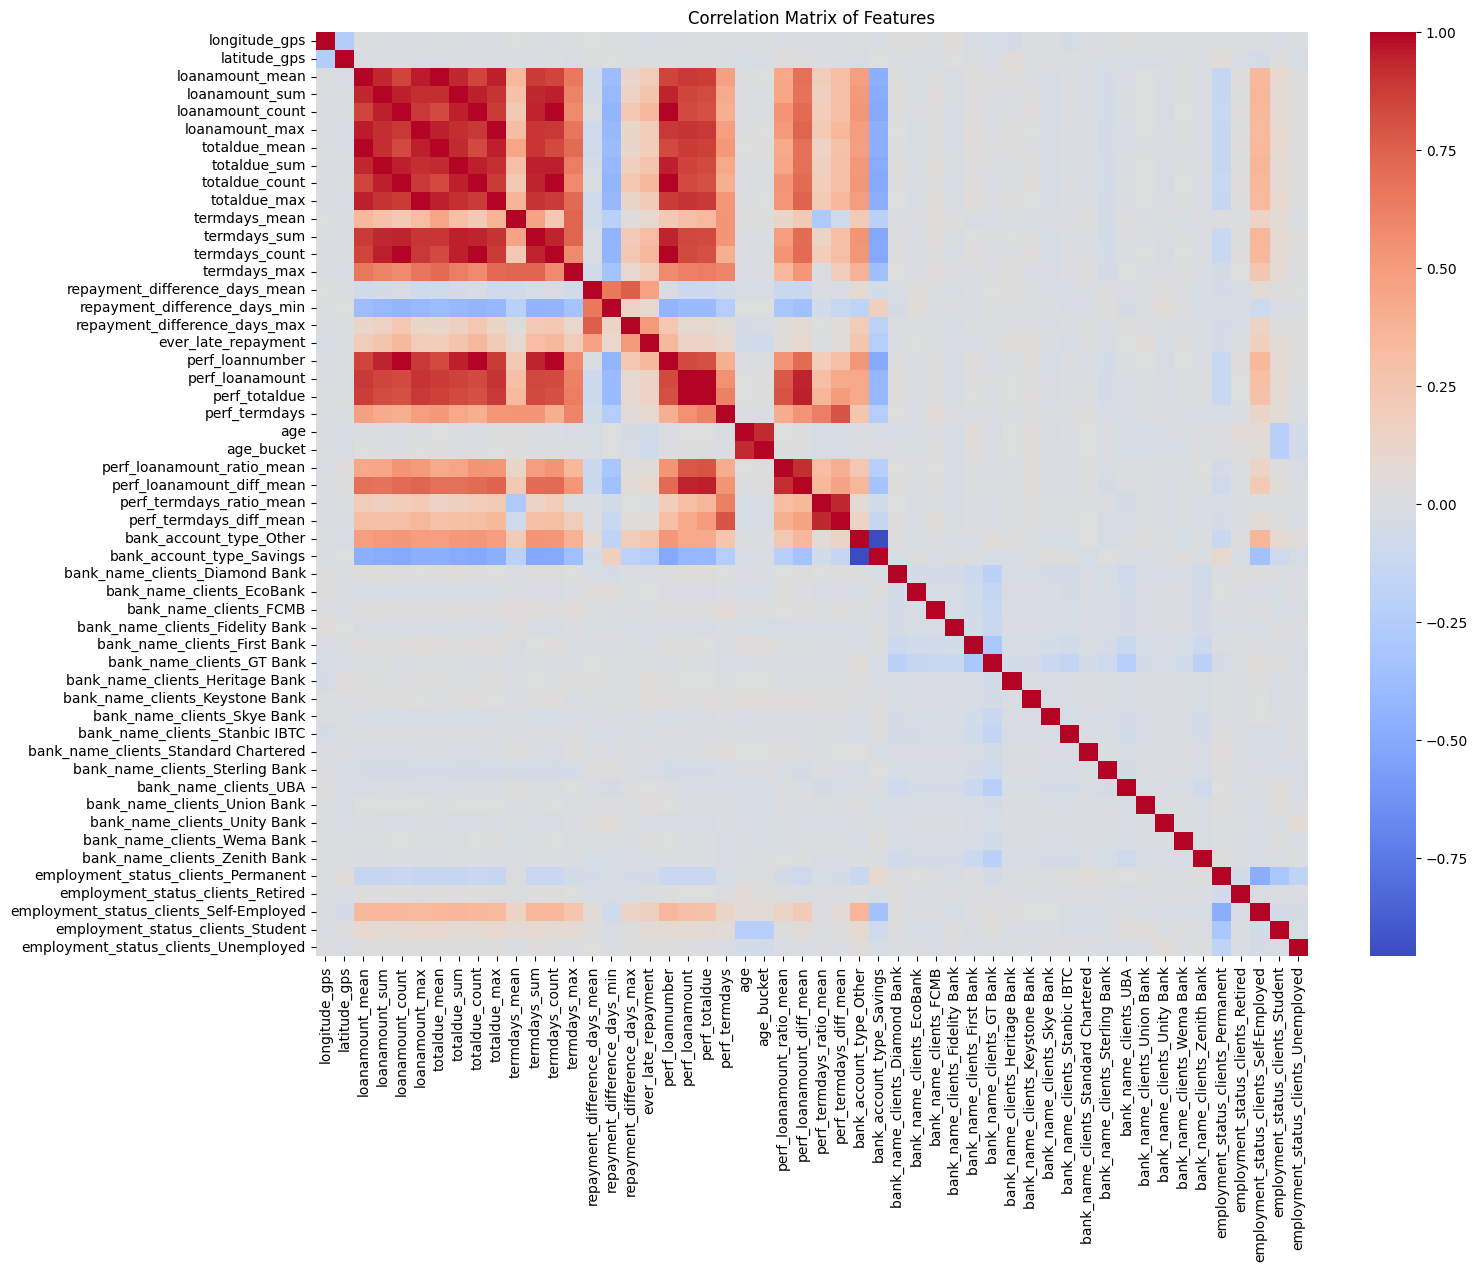


Highly correlated features (absolute correlation > 0.8):
['loanamount_sum', 'loanamount_count', 'loanamount_max', 'totaldue_mean', 'totaldue_sum', 'totaldue_count', 'totaldue_max', 'termdays_sum', 'termdays_count', 'perf_loannumber', 'perf_loanamount', 'perf_totaldue', 'age_bucket', 'perf_loanamount_diff_mean', 'perf_termdays_diff_mean', 'bank_account_type_Savings']

Pairs of highly correlated features (absolute correlation > 0.8):
loanamount_sum and loanamount_mean: 0.9364
loanamount_count and loanamount_mean: 0.8531
loanamount_count and loanamount_sum: 0.9465
loanamount_max and loanamount_mean: 0.9594
loanamount_max and loanamount_sum: 0.9179
loanamount_max and loanamount_count: 0.8871
totaldue_mean and loanamount_mean: 0.9924
totaldue_mean and loanamount_sum: 0.9197
totaldue_mean and loanamount_count: 0.8363
totaldue_mean and loanamount_max: 0.9501
totaldue_sum and loanamount_mean: 0.9386
totaldue_sum and loanamount_sum: 0.9992
totaldue_sum and loanamount_count: 0.9504
totaldue_sum

In [16]:
# Calculate the correlation matrix for the features DataFrame
correlation_matrix = features.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False) # annot=False for readability with many features
plt.title('Correlation Matrix of Features')
plt.show()

# Identify highly correlated features (threshold e.g., > 0.8 or < -0.8)
# We can also print pairs with high absolute correlation for more detailed analysis
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop_highly_correlated = [column for column in upper.columns if any(upper[column].abs() > 0.8)]

print("\nHighly correlated features (absolute correlation > 0.8):")
print(to_drop_highly_correlated)

# Print pairs of highly correlated features
highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_pairs.append((colname_i, colname_j, correlation_matrix.iloc[i, j]))

print("\nPairs of highly correlated features (absolute correlation > 0.8):")
for pair in highly_correlated_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.4f}")


### Revisit feature selection
Select a subset of features, eliminating features which are irrelevant or which have a high multicollinearity with other features. **Ocam's Razor **principle - a simpler model is a better model.


In [17]:
# 1. Identify features with very low importance (e.g., importance < 0.01)
low_importance_features = sorted_feature_importances[sorted_feature_importances < 0.01].index.tolist()
print(f"Features with very low importance (< 0.01): {low_importance_features}")

# 2. Handle highly correlated features (absolute correlation > 0.8)
# Based on the previous correlation analysis and feature importances:
# - Aggregations of loanamount, totaldue, termdays are highly correlated. Keep one representative and possibly sum/count.
#   Keep: loanamount_mean, loanamount_count, totaldue_mean, totaldue_count, termdays_mean, termdays_count
# - Performance loan number is highly correlated with previous loan counts. Keep perf_loannumber.
# - Performance loan amount and totaldue are correlated with previous loan amounts and ratios. Keep performance metrics and ratios/diffs.
#   Keep: perf_loanamount, perf_totaldue, perf_termdays, perf_loanamount_ratio_mean, perf_loanamount_diff_mean, perf_termdays_ratio_mean, perf_termdays_diff_mean
# - Repayment difference features are important and somewhat correlated but keep them as they capture different aspects of repayment behavior.
#   Keep: repayment_difference_days_mean, repayment_difference_days_min, repayment_difference_days_max, ever_late_repayment
# - Age, longitude, latitude are important and not highly correlated with other features.
#   Keep: age bucket, longitude_gps, latitude_gps
# - One-hot encoded bank account type: 'bank_account_type_Savings' and 'bank_account_type_Other' are highly negatively correlated. Keep one, e.g., 'bank_account_type_Savings'.
# - One-hot encoded bank names and employment statuses had generally lower importance. Keep those with higher importance or drop if very low.

# Initial list of features to keep based on importance and initial correlation review
features_to_keep = [
    'repayment_difference_days_mean',
    'repayment_difference_days_max',
    'age_bucket',
    'longitude_gps',
    'latitude_gps',
    'repayment_difference_days_min',
    'ever_late_repayment',
    'totaldue_sum', # Keep sum as well for total exposure
    'totaldue_mean',
    'termdays_sum', # Keep sum as well for total term
    'termdays_mean',
    'perf_termdays_diff_mean',
    'perf_termdays_ratio_mean',
    'loanamount_sum', # Keep sum for total amount borrowed
    'loanamount_mean',
    'perf_totaldue',
    'perf_loanamount_ratio_mean',
    'perf_loanamount_diff_mean',
    'totaldue_max',
    'loanamount_mean', # Already added, ensure uniqueness later
    'bank_account_type_Savings', # Keep one from the highly correlated pair
    'perf_loanamount',
    'perf_termdays',
    'loanamount_count', # Keep count for number of previous loans
    'totaldue_count', # Redundant with loanamount_count, drop one. Keep loanamount_count.
    'termdays_count', # Redundant with loanamount_count, drop one. Keep loanamount_count.
    'perf_loannumber', # Highly correlated with loanamount_count, but keep both for now.
]

# Add categorical features with some importance based on the sorted list (threshold e.g., > 0.003)
categorical_features_to_add = sorted_feature_importances[(sorted_feature_importances > 0.003) & (sorted_feature_importances.index.str.contains('_'))].index.tolist()
features_to_keep.extend(categorical_features_to_add)


# Refine the list - remove low importance features and redundant correlated features
features_to_keep = [feat for feat in features_to_keep if feat not in low_importance_features]

# Address specific highly correlated numerical features based on the previous output:
# Pairs like (loanamount_mean, loanamount_sum), (loanamount_mean, loanamount_count), etc.
# Keep mean, sum, and count as they represent different aspects (average, total, frequency)
# Drop max from these groups as mean/sum/count capture the overall scale and frequency
features_to_drop_correlated_numerical = [
    'loanamount_max',
    'totaldue_max',
    'termdays_max',
    # 'totaldue_count', # Redundant with loanamount_count, was implicitly handled by not adding it explicitly
    # 'termdays_count', # Redundant with loanamount_count, was implicitly handled by not adding it explicitly
]

features_to_keep = [feat for feat in features_to_keep if feat not in features_to_drop_correlated_numerical]


# Ensure uniqueness and order the features
features_to_keep = list(dict.fromkeys(features_to_keep))


print(f"\nNumber of selected features: {len(features_to_keep)}")
print(f"Selected features: {features_to_keep}")


# 3. Create the new DataFrame with selected features
features_selected = features[features_to_keep]

# 4. Display the head and shape of the features_selected DataFrame
display(features_selected.head())
print("Selected Features DataFrame shape:", features_selected.shape)


Features with very low importance (< 0.01): ['bank_name_clients_GT Bank', 'bank_account_type_Other', 'perf_termdays', 'perf_loanamount', 'bank_name_clients_UBA', 'loanamount_max', 'bank_name_clients_EcoBank', 'bank_name_clients_Skye Bank', 'bank_name_clients_First Bank', 'bank_name_clients_Zenith Bank', 'employment_status_clients_Student', 'termdays_max', 'employment_status_clients_Self-Employed', 'bank_name_clients_Fidelity Bank', 'bank_name_clients_FCMB', 'bank_name_clients_Diamond Bank', 'bank_name_clients_Sterling Bank', 'employment_status_clients_Unemployed', 'bank_name_clients_Stanbic IBTC', 'bank_name_clients_Unity Bank', 'bank_name_clients_Wema Bank', 'bank_name_clients_Keystone Bank', 'bank_name_clients_Heritage Bank', 'bank_name_clients_Union Bank', 'bank_name_clients_Standard Chartered', 'employment_status_clients_Retired']

Number of selected features: 24
Selected features: ['repayment_difference_days_mean', 'repayment_difference_days_max', 'age_bucket', 'longitude_gps', 'l

,repayment_difference_days_mean,repayment_difference_days_max,age_bucket,longitude_gps,latitude_gps,repayment_difference_days_min,ever_late_repayment,totaldue_sum,totaldue_mean,termdays_sum,termdays_mean,perf_termdays_diff_mean,perf_termdays_ratio_mean,loanamount_sum,loanamount_mean,perf_totaldue,perf_loanamount_ratio_mean,perf_loanamount_diff_mean,bank_account_type_Savings,loanamount_count,totaldue_count,termdays_count,perf_loannumber,employment_status_clients_Permanent
0,-1.000000,-1.0,4,3.319219,6.528604,-1.0,0.0,11500.0,11500.0,15.0,15.0,15.0,2.0,10000.0,10000.0,13000.0,1.000000,0.0,True,1.0,1.0,1.0,2.0,False
1,3.000000,3.0,2,3.325598,7.119403,3.0,1.0,13000.0,13000.0,30.0,30.0,0.0,1.0,10000.0,10000.0,13000.0,1.000000,0.0,True,1.0,1.0,1.0,2.0,True
2,0.333333,4.0,1,5.746100,5.563174,-4.0,1.0,36000.0,12000.0,60.0,20.0,10.0,1.5,30000.0,10000.0,13000.0,1.000000,0.0,True,3.0,3.0,3.0,4.0,False
3,18.000000,18.0,0,3.362850,6.642485,18.0,1.0,11500.0,11500.0,15.0,15.0,0.0,1.0,10000.0,10000.0,11500.0,1.000000,0.0,True,1.0,1.0,1.0,2.0,True
6,-3.200000,0.0,0,3.365935,6.564823,-7.0,0.0,88000.0,17600.0,150.0,30.0,0.0,1.0,70000.0,14000.0,24500.0,1.428571,6000.0,True,5.0,5.0,5.0,6.0,True


Selected Features DataFrame shape: (3272, 24)


# Using smote to address imbalanced data

There are far more loans that are repaid (category 0) than are defaulted (category 1) in the data set. This often causes poor results in ML models. Smote is a method of oversampling the smaller class to achieve a balance of items.

In [18]:
from imblearn.over_sampling import SMOTE

# Before applying SMOTE, let's check the class distribution
print("Class distribution before SMOTE:")
display(y_train.value_counts())

# Apply SMOTE to the training data
smote = SMOTE(random_state=32)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("\nClass distribution after SMOTE:")
display(y_train_resampled.value_counts())

print("\nShape of X_train_resampled:", X_train_resampled.shape)
print("Shape of y_train_resampled:", y_train_resampled.shape)

Class distribution before SMOTE:


,count
perf_good_bad_flag,
0,1536
1,427



Class distribution after SMOTE:


,count
perf_good_bad_flag,
0,1536
1,1536



Shape of X_train_resampled: (3072, 52)
Shape of y_train_resampled: (3072,)


## Section 6: Train and evaluate models (revisited - part 2)

After reducing the number of paramters are the models able to produce better results?

AdaBoost was the best performing model previously. The range of hyper-paramters for this model has been widened to try to fine tune and improve model perofrmance.


In [19]:
# Section 4: Model Training & Hyperparameter Tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
# Add XGBoost and LightGBM
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 4.1 Train/Test Split (60% train, 40% validation)
X_train, X_val, y_train, y_val = train_test_split(
    features, target,
    test_size=0.4,
    random_state=32,
    stratify=target
)

# 4.2 Define models and hyperparameter grids Note that range of paramters for AdaBoost has been widened
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, solver='saga', random_state=32),
        'params': {'C': [0.1, 1, 10], 'penalty': ['l2']}
    },
    'LassoLogistic': {
        'model': LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=32),
        'params': {'C': [0.1, 1, 10]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=32),
        'params': {'n_estimators': [100, 150], 'max_depth': [None, 10], 'min_samples_split': [2, 5]}
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=32),
        'params': {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=32),
        'params': {'n_estimators': [80, 90, 100, 110, 120], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
    },
    'KNeighbors': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']}
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=32),
        'params': {'n_estimators': [100], 'max_depth': [3, 5]}
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=32),
        'params': {'n_estimators': [100], 'num_leaves': [31, 63]}
    }
}

# 4.3 Hyperparameter Tuning with GridSearchCV
best_estimators = {}
for name, cfg in models.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(
        cfg['model'],
        cfg['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    print(f"Best params for {name}: {grid.best_params_}")
    best_estimators[name] = grid.best_estimator_

# 4.4 Evaluation on Validation Set
for name, model in best_estimators.items():
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    print(f"\n=== {name} ===")
    print(classification_report(y_val, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_val, y_proba):.4f}")


Tuning LogisticRegression...
Best params for LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
Tuning LassoLogistic...
Best params for LassoLogistic: {'C': 1}
Tuning RandomForest...
Best params for RandomForest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Tuning GradientBoosting...
Best params for GradientBoosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Tuning AdaBoost...
Best params for AdaBoost: {'learning_rate': 0.3, 'n_estimators': 90}
Tuning KNeighbors...
Best params for KNeighbors: {'n_neighbors': 5, 'weights': 'distance'}
Tuning XGBoost...
Best params for XGBoost: {'max_depth': 3, 'n_estimators': 100}
Tuning LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 427, number of negative: 1536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

# Section 7: Select best model and conclusion


The best model performance so far is with AdaBoost with an accuracy of 79% and an ROC AUC of 0.6932.

It performs well for the majority class - with a precision of 82% (meaning 82% of the real positives are predicted as positive) and a recall of 94% (meaning that 94% of the loans predicted as positive are actually positive)

However this model is not performing well for the minority class despite using smote to balance the classes with only 54% precision and 25% accuracy.

**Further work**
If i had more time I would explore the latitude/longitude further. For example consider if there is clustering of points or perhaps creating a new urban/rural variable based on the location of large cities in Nigeria.
I would also revisit the flattening of the previous loan data to see if I could only extract pertinent information from this data focussed on behavioural credit risk.

It is also possible that the data is not yet adequate to built a robust model. So collecting more data and perhaps including more variables would improve the model. There were some potentially useful variables which were deleted due to more than 80% missing data, so filling these gaps could improve the model.

**Business interpretation**
This model could be used as an aid to loan decision making but the final decision should rest with humans. This is for two reasons. Firstly the model is not yet accurate enough to avoid making loans to borrowers who are likely to default. Secondly from an ethical perspective purely machine based decisions for lending are not usually encouraged by regulators in the banking industry.
